Data madness setup

In [189]:
#Imports
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

import sys

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

pd.set_option('display.max_rows', 50)
np.set_printoptions(linewidth=50)
np.set_printoptions(threshold=999)

In [190]:
# Load 
complete_data = pd.read_csv("athlete_events.csv")

print(complete_data.columns.values)
#1. ID - Row numbers
#2. Name - Athlete's name
#3. Sex - M or F
#4. Age - Integer
#5. Height - In centimeters
#6. Weight - In kilograms
#7. Team - Team name
#8. NOC - National Olympic Committee 3-letter code
#9. Games - Year and season
#10. Year - Integer
#11. Season - Summer or Winter
#12. City - Host city
#13. Sport - Sport
#14. Event - Event
#15. Medal - Gold, Silver, Bronze, or NA
complete_data.head(5)

['ID' 'Name' 'Sex' 'Age' 'Height' 'Weight' 'Team'
 'NOC' 'Games' 'Year' 'Season' 'City' 'Sport'
 'Event' 'Medal']


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [207]:
# drop rows where age is NaN
# complete_data = complete_data.dropna(subset=['Age'])

In [208]:
# Clean data #TODO

# maybe we replace some NaN values

# Electronic clocks only started since 1936 (we could do something with that)

In [209]:
# Functions

# Medal conversion to numeric columns
def convert_medals(data):
    types = ['NA', 'Gold', 'Silver', 'Bronze']
    
    cat_type = CategoricalDtype(categories=types)
    
    data['Medal'] = data['Medal'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='mdl',
                          columns=['Medal'], 
                          drop_first=True)
    
    return data

In [210]:
# Order & group by queries

# Medals
Medals = convert_medals(complete_data)
Medals = Medals[Medals.Year > 2000]
Medals = Medals[['Name', 'Team', 'Games', 'Sport', 'mdl_Gold', 'mdl_Silver', 'mdl_Bronze', "Age"]]

Medal_counts = Medals.groupby(['Name', 'Team', 'Games', 'Sport'], as_index=False).sum()
Medal_counts = Medal_counts.sort_values('Games')
Medal_counts.head(10)


,Name,Team,Games,Sport,mdl_Gold,mdl_Silver,mdl_Bronze,Age
47505,"Theoren Wallace ""Theo"" Fleury",Canada,2002 Winter,Ice Hockey,1,0,0,33.0
37503,Olga Valeryevna Danilova,Russia,2002 Winter,Cross Country Skiing,0,0,0,93.0
37505,Olga Valeryevna Pylyova-Medvedtseva (Zamorozova-),Russia,2002 Winter,Biathlon,1,0,1,104.0
25996,Kristen Skjeldal,Norway,2002 Winter,Cross Country Skiing,1,0,1,102.0
25991,"Kristen Elizabeth ""Krissy"" Wendell (-Pohl)",United States,2002 Winter,Ice Hockey,0,1,0,20.0
15336,Fulvio Valbusa,Italy,2002 Winter,Cross Country Skiing,0,0,0,96.0
15338,Fumie Suguri,Japan,2002 Winter,Figure Skating,0,0,0,21.0
25972,Kristan Lee Bromley,Great Britain,2002 Winter,Skeleton,0,0,0,29.0
37515,Olga Viktorovna Nazarova,Belarus,2002 Winter,Biathlon,0,0,0,96.0
37519,Olga Viktorovna Permyakova,Russia,2002 Winter,Ice Hockey,0,0,0,19.0


In [211]:
mc = Medal_counts[Medal_counts["Age"] > 0]
# filter out the ones without a medal, gold + silver + bronze = 0
mc = mc[mc["mdl_Gold"] + mc["mdl_Silver"] + mc["mdl_Bronze"] == 0]
mc

,Name,Team,Games,Sport,mdl_Gold,mdl_Silver,mdl_Bronze,Age
37503,Olga Valeryevna Danilova,Russia,2002 Winter,Cross Country Skiing,0,0,0,93.0
15336,Fulvio Valbusa,Italy,2002 Winter,Cross Country Skiing,0,0,0,96.0
15338,Fumie Suguri,Japan,2002 Winter,Figure Skating,0,0,0,21.0
25972,Kristan Lee Bromley,Great Britain,2002 Winter,Skeleton,0,0,0,29.0
37515,Olga Viktorovna Nazarova,Belarus,2002 Winter,Biathlon,0,0,0,96.0
...,...,...,...,...,...,...,...,...
42074,Ruben Scheire,Belgium,2016 Summer,Cycling,0,0,0,24.0
18636,Igor Petrovich Pashevich,Belarus,2016 Summer,Rowing,0,0,0,24.0
42078,Rubens Valeriano Donizete,Brazil,2016 Summer,Cycling,0,0,0,36.0
18634,Igor Olshanetskyi,Israel,2016 Summer,Weightlifting,0,0,0,30.0


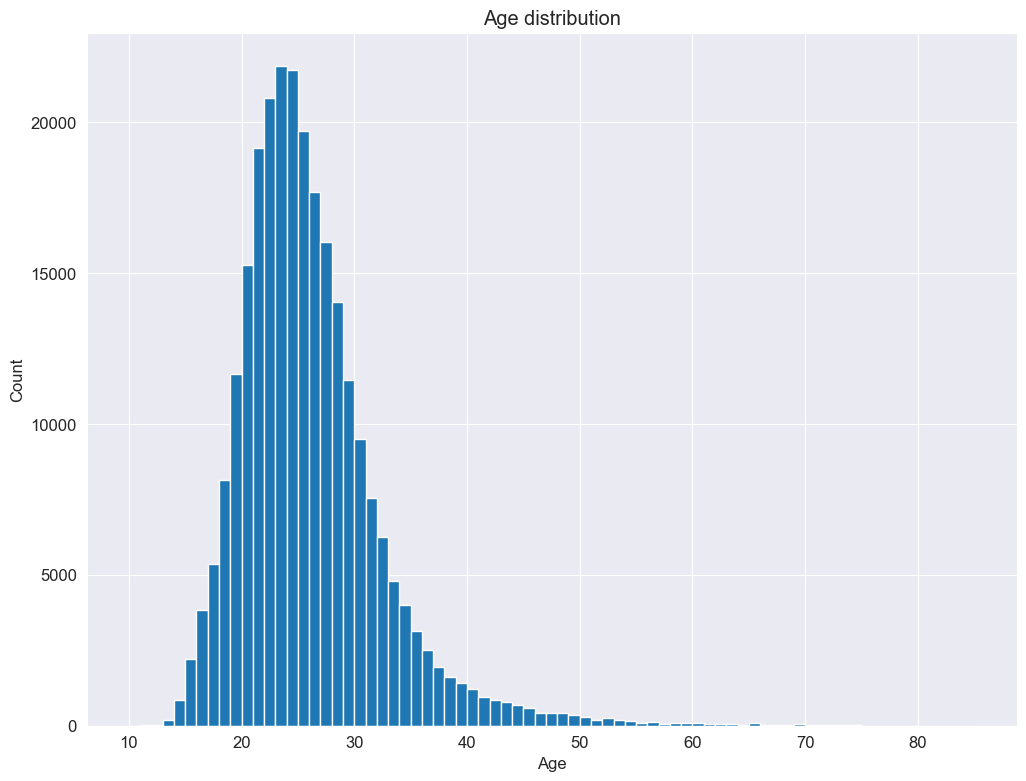

In [212]:
# age histogram
plt.hist(complete_data.Age, bins=75, range=(10, 85))
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution')
plt.show()

In [213]:
min(complete_data.Age.unique())

10.0

In [214]:
max(complete_data.Age.unique())

97.0

In [233]:
# dropna on medal
meds = complete_data.dropna(subset=['Medal'])
meds

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
37,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 200 metres Breaststroke,Bronze
38,15,Arvo Ossian Aaltonen,M,30.0,NaN,NaN,Finland,FIN,1920 Summer,1920,Summer,Antwerpen,Swimming,Swimming Men's 400 metres Breaststroke,Bronze
40,16,Juhamatti Tapio Aaltonen,M,28.0,184.0,85.0,Finland,FIN,2014 Winter,2014,Winter,Sochi,Ice Hockey,Ice Hockey Men's Ice Hockey,Bronze
41,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Individual All-Around,Bronze
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271078,135553,Galina Ivanovna Zybina (-Fyodorova),F,25.0,168.0,80.0,Soviet Union,URS,1956 Summer,1956,Summer,Melbourne,Athletics,Athletics Women's Shot Put,Silver
271080,135553,Galina Ivanovna Zybina (-Fyodorova),F,33.0,168.0,80.0,Soviet Union,URS,1964 Summer,1964,Summer,Tokyo,Athletics,Athletics Women's Shot Put,Bronze
271082,135554,Bogusaw Zych,M,28.0,182.0,82.0,Poland,POL,1980 Summer,1980,Summer,Moskva,Fencing,"Fencing Men's Foil, Team",Bronze
271102,135563,Olesya Nikolayevna Zykina,F,19.0,171.0,64.0,Russia,RUS,2000 Summer,2000,Summer,Sydney,Athletics,Athletics Women's 4 x 400 metres Relay,Bronze


In [234]:
# get diff between complete data and meds
nomeds = pd.concat([complete_data, meds]).drop_duplicates(keep=False)
nomeds

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


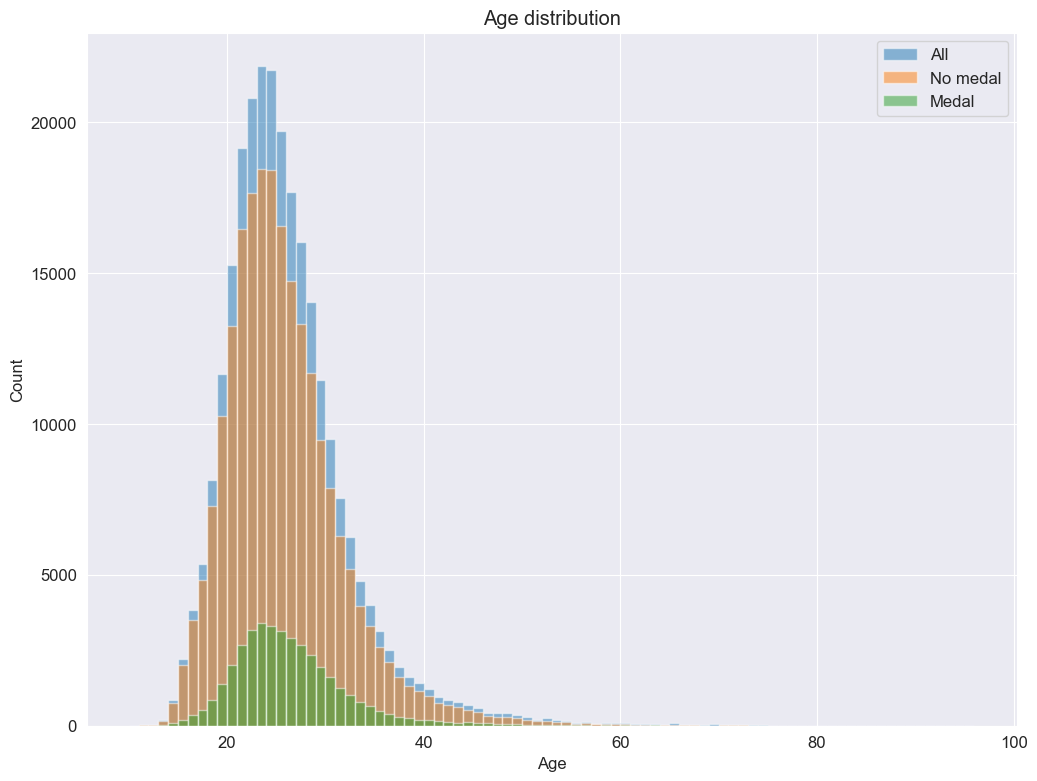

In [235]:
# make 2 histograms with mc and md, age
# do subplots

fig = plt.figure()
plt.hist(complete_data.Age, bins=range(10, 97), alpha=0.5, label='All')
plt.hist(nomeds.Age, bins=range(10, 97), alpha=0.5, label='No medal')
plt.hist(meds.Age,  bins=range(10, 97), alpha=0.5, label='Medal')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age distribution')
plt.legend(loc='upper right')
plt.show()
